In [1]:
import math
import numpy as np
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

In [2]:
#Data Source
import yfinance as yf

In [3]:
# #Data viz
# import plotly.graph_objs as go

# live market data from yfinance

In [4]:
def AutoData(name,p,t):
    data = yf.download(tickers=name, period=p, interval=t)
    return data

In [5]:
data = AutoData('GAIL.NS', '5y', '1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-04,139.500031,144.000031,138.750031,141.656281,114.183464,8528251
2017-08-07,142.762527,144.337540,142.200027,143.100037,115.347206,8635488
2017-08-08,143.100037,146.062531,142.987534,145.031281,116.903893,8628448
2017-08-09,145.875031,146.006287,142.218781,143.325027,115.528557,4698481
2017-08-10,142.800034,143.343781,135.000031,136.875031,110.329483,7045715
...,...,...,...,...,...,...
2022-07-28,147.750000,147.899994,145.300003,145.949997,144.954437,5649223
2022-07-29,147.300003,147.850006,146.100006,146.600006,145.600006,4676585
2022-08-01,146.600006,148.800003,146.550003,147.300003,147.300003,6885952


In [6]:
df = pd.DataFrame(data, columns=['Close'])
df.head()

,Close
Date,
2017-08-04,141.656281
2017-08-07,143.100037
2017-08-08,145.031281
2017-08-09,143.325027
2017-08-10,136.875031


In [7]:
df.shape

(1236, 1)

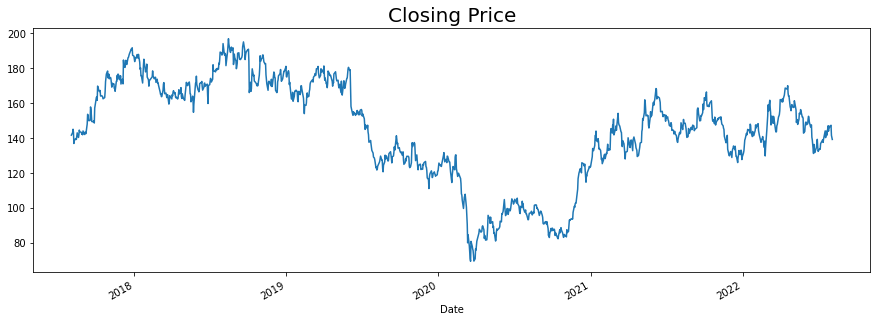

In [8]:
plt.figure(figsize=(15,5))
df.Close.plot()
plt.title("Closing Price",fontsize=20)
plt.show()

# Normalization 

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(np.array(df).reshape(-1,1))
scaled_data

array([[0.56671595],
       [0.57803953],
       [0.59318654],
       ...,
       [0.61098044],
       [0.56549022],
       [0.54745098]])

# dataset into train and test split

In [10]:
training_size=int(len(scaled_data)*0.70)
test_size=len(scaled_data)-training_size
train_data,test_data=scaled_data[0:training_size,:],scaled_data[training_size:len(scaled_data),:1]
training_size, test_size

(865, 371)

In [11]:
import numpy
def create_dataset(dataset, time_step=1):
    data_x, data_y = [], []
    for i in range(len(dataset)-time_step-1):
        a= dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        data_x.append(a)
        data_y.append(dataset[i + time_step, 0])
    return numpy.array(data_x), numpy.array(data_y)


In [12]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [13]:
x_train.shape, y_train.shape

((764, 100), (764,))

In [14]:
# Reshaping intput data to be [sample, time step, features] which is required for LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1], 1 )

x_train.shape, x_test.shape

((764, 100, 1), (270, 100, 1))

# Create the Stacked LSTM model

In [15]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [16]:
#Building Model
LSTM_model=Sequential()
LSTM_model.add(LSTM(50, return_sequences=True,input_shape=(100,1)))
LSTM_model.add(LSTM(50, return_sequences=True))
LSTM_model.add(LSTM(50))
LSTM_model.add(Dense(1,activation='linear'))

In [17]:
#Compiling the model
LSTM_model.compile(loss='mse', optimizer='adam')

In [18]:
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [62]:
#Fitting the model
history = LSTM_model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=120, batch_size = 64, verbose=1)

Epoch 1/120
12/12 [==============================] - 1s 105ms/step - loss: 9.8546e-04 - val_loss: 8.1284e-04
Epoch 2/120
12/12 [==============================] - 1s 103ms/step - loss: 9.1183e-04 - val_loss: 7.7848e-04
Epoch 3/120
12/12 [==============================] - 1s 105ms/step - loss: 9.0923e-04 - val_loss: 8.0679e-04
Epoch 4/120
12/12 [==============================] - 1s 107ms/step - loss: 8.7332e-04 - val_loss: 7.6729e-04
Epoch 5/120
12/12 [==============================] - 1s 106ms/step - loss: 0.0010 - val_loss: 8.4424e-04
Epoch 6/120
12/12 [==============================] - 1s 108ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 7/120
12/12 [==============================] - 1s 112ms/step - loss: 9.0603e-04 - val_loss: 7.4229e-04
Epoch 8/120
12/12 [==============================] - 1s 110ms/step - loss: 9.4085e-04 - val_loss: 0.0012
Epoch 9/120
12/12 [==============================] - 1s 109ms/step - loss: 9.7900e-04 - val_loss: 7.2870e-04
Epoch 10/120
12/12 [===============

Epoch 76/120
12/12 [==============================] - 1s 114ms/step - loss: 6.5852e-04 - val_loss: 5.9707e-04
Epoch 77/120
12/12 [==============================] - 1s 116ms/step - loss: 6.1449e-04 - val_loss: 5.4751e-04
Epoch 78/120
12/12 [==============================] - 1s 118ms/step - loss: 6.9980e-04 - val_loss: 7.6233e-04
Epoch 79/120
12/12 [==============================] - 1s 115ms/step - loss: 8.3025e-04 - val_loss: 5.6757e-04
Epoch 80/120
12/12 [==============================] - 1s 112ms/step - loss: 6.9539e-04 - val_loss: 6.3715e-04
Epoch 81/120
12/12 [==============================] - 1s 116ms/step - loss: 8.4769e-04 - val_loss: 8.9587e-04
Epoch 82/120
12/12 [==============================] - 1s 122ms/step - loss: 8.0426e-04 - val_loss: 0.0011
Epoch 83/120
12/12 [==============================] - 1s 122ms/step - loss: 7.9851e-04 - val_loss: 5.9176e-04
Epoch 84/120
12/12 [==============================] - 1s 121ms/step - loss: 6.0598e-04 - val_loss: 5.5324e-04
Epoch 85/120
1

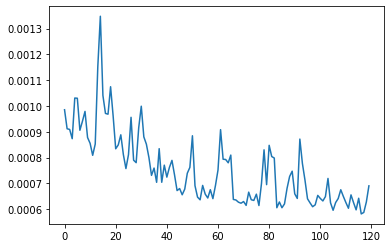

In [63]:
#Plotting loss, it shows that loss has decreased significantly and model trained well
loss=LSTM_model.history.history['loss']
plt.plot(loss)

In [64]:
# Lets do the prediction and performance 
train_predict = LSTM_model.predict(x_train)
test_predict  = LSTM_model.predict(x_test)

9/9 [==============================] - 0s 18ms/step


In [65]:
#Transformback to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict  = scaler.inverse_transform(test_predict)

In [66]:
LSTM_model.save('saved_model.h5')

In [67]:
# Shift train predictions
step = 100
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:,:] = np.nan
train_predict_plot[step:len(train_predict)+step, :] = train_predict

# Shift test predictions
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:,:] = np.nan
test_predict_plot[len(train_predict)+(step*2)+1:len(scaled_data) - 1, :] = test_predict

# Predictions

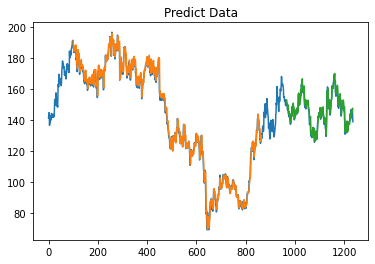

In [68]:
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(train_predict_plot,)
plt.plot(test_predict_plot)
plt.title('Predict Data')
plt.show()

1. Green indicates the Predicted Data
2. Blue indicates the Complete Data
3. Orange indicates the Train Data

In [69]:
test_input = test_data[271:].reshape(1,-1)

In [70]:
y_input = list(test_input)
x_input = y_input[0].tolist()

In [71]:
x_input

[0.6509803712720907,
 0.6505883101273069,
 0.6200000011967679,
 0.6509803712720907,
 0.6423529915815163,
 0.5874510275119575,
 0.5807843125756544,
 0.5819608550403583,
 0.6094118370751378,
 0.6137254670820329,
 0.6486275256962513,
 0.6529411557031464,
 0.6592156898178814,
 0.6764705688758144,
 0.7266667221169101,
 0.7239215760427185,
 0.7164706191400638,
 0.7290196873695338,
 0.7160784383184959,
 0.7274509640832618,
 0.7466667472490347,
 0.7631372646638319,
 0.7784313592907093,
 0.7729411868191103,
 0.7890196430891236,
 0.7545098849732574,
 0.7419608167437874,
 0.7435294203532752,
 0.6937255676105316,
 0.6874510334957966,
 0.6764705688758144,
 0.6933333867889637,
 0.7039215509105938,
 0.6913726023579081,
 0.6913726023579081,
 0.7211765496453111,
 0.7121568694563845,
 0.680000076593142,
 0.6235293892373113,
 0.6372548802547011,
 0.6345098538572935,
 0.6149020095467368,
 0.637647061076269,
 0.6650980431110485,
 0.6607842934273691,
 0.6615686550705051,
 0.6815686802026297,
 0.657254905386

# Forcasting stock price for next 2 month

In [72]:
forcasting_stock_price = []
step = 100
Next_forcast_days = 30
i=0    
while(i<Next_forcast_days):        
    if(len(x_input)>step):
        #printing x_input
        test_input = np.array(x_input[1:])
        print("{} day input {}".format(i,test_input))
        test_input = test_input.reshape(1,-1)
        test_input=test_input.reshape((1, step, 1))
        
        #printing test_input
        y_predict = LSTM_model.predict(test_input, verbose=0)
        print("{} day output {}".format(i,y_predict))
        x_input.extend(y_predict[0].tolist())
        x_input = x_input[1:]
        forcasting_stock_price.extend(y_predict.tolist())
        i=i+1
        
    else:
        test_input = test_input.reshape(1,step,1)
        y_predict = LSTM_model.predict(test_input, verbose=0)
        print(y_predict[0])
        x_input.extend(y_predict[0].tolist())
        print(len(x_input))
        forcasting_stock_price.extend(y_predict.tolist())
        i=i+1
        
print((forcasting_stock_price))

[0.55138266]
101
1 day input [0.65058831 0.62       0.65098037 0.64235299 0.58745103 0.58078431
 0.58196086 0.60941184 0.61372547 0.64862753 0.65294116 0.65921569
 0.67647057 0.72666672 0.72392158 0.71647062 0.72901969 0.71607844
 0.72745096 0.74666675 0.76313726 0.77843136 0.77294119 0.78901964
 0.75450988 0.74196082 0.74352942 0.69372557 0.68745103 0.67647057
 0.69333339 0.70392155 0.6913726  0.6913726  0.72117655 0.71215687
 0.68000008 0.62352939 0.63725488 0.63450985 0.61490201 0.63764706
 0.66509804 0.66078429 0.66156866 0.68156868 0.65725491 0.64784316
 0.64862753 0.64156863 0.57568632 0.58313728 0.61019608 0.62431375
 0.62549017 0.61333341 0.61764704 0.64000003 0.65137255 0.64431378
 0.62509811 0.6031373  0.60823529 0.61294123 0.55764708 0.54549019
 0.48431369 0.52509811 0.50352948 0.48862744 0.4945098  0.51176468
 0.52941174 0.54784316 0.51607843 0.49372556 0.5031373  0.50509808
 0.5031373  0.52862749 0.53215688 0.54274517 0.54588237 0.53411767
 0.54823534 0.5572549  0.58588242

11 day output [[0.6113951]]
12 day input [0.65921569 0.67647057 0.72666672 0.72392158 0.71647062 0.72901969
 0.71607844 0.72745096 0.74666675 0.76313726 0.77843136 0.77294119
 0.78901964 0.75450988 0.74196082 0.74352942 0.69372557 0.68745103
 0.67647057 0.69333339 0.70392155 0.6913726  0.6913726  0.72117655
 0.71215687 0.68000008 0.62352939 0.63725488 0.63450985 0.61490201
 0.63764706 0.66509804 0.66078429 0.66156866 0.68156868 0.65725491
 0.64784316 0.64862753 0.64156863 0.57568632 0.58313728 0.61019608
 0.62431375 0.62549017 0.61333341 0.61764704 0.64000003 0.65137255
 0.64431378 0.62509811 0.6031373  0.60823529 0.61294123 0.55764708
 0.54549019 0.48431369 0.52509811 0.50352948 0.48862744 0.4945098
 0.51176468 0.52941174 0.54784316 0.51607843 0.49372556 0.5031373
 0.50509808 0.5031373  0.52862749 0.53215688 0.54274517 0.54588237
 0.53411767 0.54823534 0.5572549  0.58588242 0.5556863  0.5658824
 0.5843137  0.56627458 0.60862748 0.58470588 0.60666669 0.60039216
 0.60549027 0.61098044 0

23 day output [[0.6687341]]
24 day input [0.78901964 0.75450988 0.74196082 0.74352942 0.69372557 0.68745103
 0.67647057 0.69333339 0.70392155 0.6913726  0.6913726  0.72117655
 0.71215687 0.68000008 0.62352939 0.63725488 0.63450985 0.61490201
 0.63764706 0.66509804 0.66078429 0.66156866 0.68156868 0.65725491
 0.64784316 0.64862753 0.64156863 0.57568632 0.58313728 0.61019608
 0.62431375 0.62549017 0.61333341 0.61764704 0.64000003 0.65137255
 0.64431378 0.62509811 0.6031373  0.60823529 0.61294123 0.55764708
 0.54549019 0.48431369 0.52509811 0.50352948 0.48862744 0.4945098
 0.51176468 0.52941174 0.54784316 0.51607843 0.49372556 0.5031373
 0.50509808 0.5031373  0.52862749 0.53215688 0.54274517 0.54588237
 0.53411767 0.54823534 0.5572549  0.58588242 0.5556863  0.5658824
 0.5843137  0.56627458 0.60862748 0.58470588 0.60666669 0.60039216
 0.60549027 0.61098044 0.56549022 0.54745098 0.55138266 0.55924743
 0.56767094 0.57454777 0.58026713 0.58520591 0.58968091 0.59394068
 0.5981639  0.60245782 0

In [73]:
#Plotting Forcast Predictions
Next_days = np.arange(1,len(x_input))
Forcast_Pred = np.arange(len(x_input),len(x_input)+Next_forcast_days)
Forcast_stock_price = scaled_data.tolist()
Forcast_stock_price.extend(forcasting_stock_price)

Text(0, 0.5, 'Price')

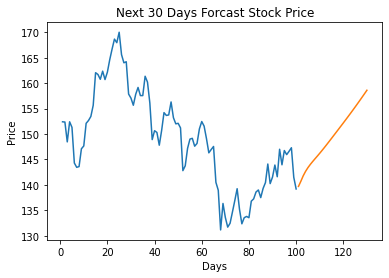

In [74]:
plt.plot(Next_days,scaler.inverse_transform(scaled_data[1136:]))
plt.plot(Forcast_Pred,scaler.inverse_transform(forcasting_stock_price))
plt.title("Next {} Days Forcast Stock Price".format(Next_forcast_days))
plt.xlabel("Days")
plt.ylabel("Price")

Text(0, 0.5, 'Price')

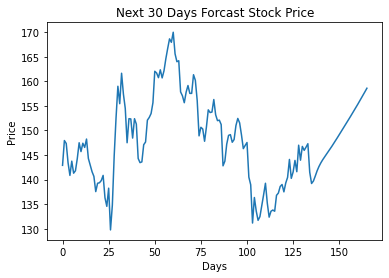

In [75]:
Forcast_stock_price = scaled_data.tolist()
Forcast_stock_price.extend(forcasting_stock_price)
plt.plot(scaler.inverse_transform(Forcast_stock_price[1100:]))
plt.title("Next {} Days Forcast Stock Price".format(Next_forcast_days))
plt.xlabel("Days")
plt.ylabel("Price")

Text(0.5, 0, 'Days')

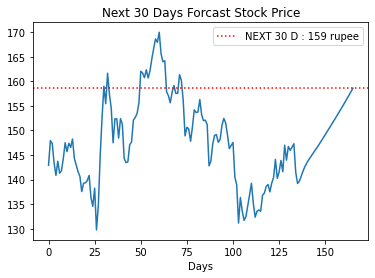

In [79]:
Forcast_stock_price = scaled_data.tolist()
Forcast_stock_price.extend(forcasting_stock_price)
output = scaler.inverse_transform(Forcast_stock_price[1100:])
plt.plot(scaler.inverse_transform(Forcast_stock_price[1100:]))
plt.title("Next {} Days Forcast Stock Price".format(Next_forcast_days))
plt.axhline(y=output[len(output) - 1], color ='red', linestyle=':',label='NEXT {} D : {} rupee'.format(Next_forcast_days,round(float(*output[len(output)-1]))))
plt.legend()
plt.xlabel("Days")